# Get image from CSI camera
- Use GStreamer & OpenCV

In [1]:
# Check if OpenCV is built with GStreamer
import cv2

"""
Video I/O:
    FFMPEG:                      YES
      avcodec:                   YES (58.54.100)
      avformat:                  YES (58.29.100)
      avutil:                    YES (56.31.100)
      swscale:                   YES (5.5.100)
      avresample:                YES (4.0.0)
    GStreamer:                   YES (1.16.2)
"""

# If GStreamer: NO, then uninstall your OpenCV to load built-in OpenCV for Jetson
"""
    $ pip3 uninstall opencv-python
"""
print(cv2.getBuildInformation())


General configuration for OpenCV 4.5.4 =====================================
  Version control:               4.5.4-8-g3e4c170df4

  Platform:
    Timestamp:                   2022-01-18T10:01:01Z
    Host:                        Linux 5.10.65-tegra aarch64
    CMake:                       3.16.3
    CMake generator:             Unix Makefiles
    CMake build tool:            /usr/bin/make
    Configuration:               Release

  CPU/HW features:
    Baseline:                    NEON FP16

  C/C++:
    Built as dynamic libs?:      YES
    C++ standard:                11
    C++ Compiler:                /usr/bin/c++  (ver 9.3.0)
    C++ flags (Release):         -fsigned-char -W -Wall -Werror=return-type -Werror=non-virtual-dtor -Werror=address -Werror=sequence-point -Wformat -Werror=format-security -Wmissing-declarations -Wundef -Winit-self -Wpointer-arith -Wshadow -Wsign-promo -Wuninitialized -Wsuggest-override -Wno-delete-non-virtual-dtor -Wno-comment -Wimplicit-fallthrough=3 -Wno

In [2]:
sensor_id = 0
downscale = 2
width, height = (1280, 720)
_width, _height = (width // downscale, height // downscale)
frame_rate = 30
flip_method = 0
contrast = 1.3
brightness = 0.2

gstreamer_pipeline = (
    "nvarguscamerasrc sensor-id=%d ! "
    "video/x-raw(memory:NVMM), width=(int)%d, height=(int)%d, framerate=(fraction)%d/1 ! "
    "nvvidconv flip-method=%d, interpolation-method=1 ! "
    "videobalance contrast=%.1f brightness=%.1f ! "
    "video/x-raw, width=(int)%d, height=(int)%d, format=(string)BGRx ! "
    "videoconvert ! "
    "video/x-raw, format=(string)BGR ! appsink"
    % (
        sensor_id,
        width,
        height,
        frame_rate,        
        flip_method,
        contrast,
        brightness,
        _width,
        _height,
    )
)

In [3]:
import cv2

camera = cv2.VideoCapture(gstreamer_pipeline, cv2.CAP_GSTREAMER)
print("Is opened: {}".format(camera.isOpened()))

GST_ARGUS: Creating output stream
CONSUMER: Waiting until producer is connected...
GST_ARGUS: Available Sensor modes :
GST_ARGUS: 3280 x 2464 FR = 21.000000 fps Duration = 47619048 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 3280 x 1848 FR = 28.000001 fps Duration = 35714284 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1920 x 1080 FR = 29.999999 fps Duration = 33333334 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1640 x 1232 FR = 29.999999 fps Duration = 33333334 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1280 x 720 FR = 59.999999 fps Duration = 16666667 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: Running with following settings:
   Camera index = 0 
   Camera mode  = 4 
   Output Stream W = 1280 H = 7

[ WARN:0] global /home/ubuntu/build_opencv/opencv/modules/videoio/src/cap_gstreamer.cpp (1100) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


### Grab an image

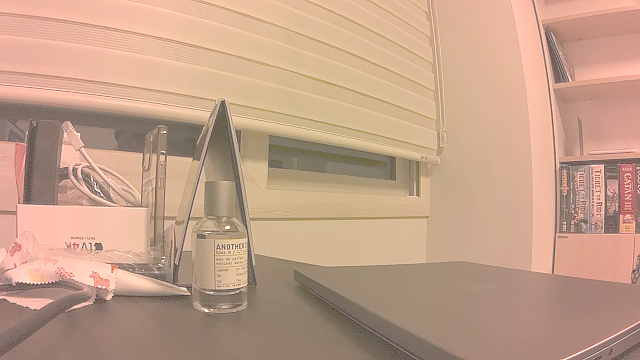

GST_ARGUS: Cleaning up
CONSUMER: Done Success
GST_ARGUS: Done Success


In [4]:
from PIL import Image

_, frame = camera.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
display(Image.fromarray(frame))
camera.release()

In [5]:
from ultralytics import YOLO
import copy
import cv2
import numpy as np
import seaborn as sns
import torch


model = YOLO("yolov8n.pytorch.pt", task='detect')

classes = model.names
colors = np.array(sns.color_palette('Paired', len(classes)))
colors = (colors * 255.0).astype(np.uint8)

image = copy.deepcopy(frame)
pred = model(image, stream=False)


0: 384x640 1 bottle, 44.3ms
Speed: 5.9ms preprocess, 44.3ms inference, 5.4ms postprocess per image at shape (1, 3, 384, 640)


In [6]:
def draw_boxes(image, pred, classes, colors):
    for r in pred:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            score = round(float(box.conf[0]), 2)
            label = int(box.cls[0])

            color = colors[label].tolist()
            cls_name = classes[label]

            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, f"{cls_name} {score}", (x1, max(0, y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)


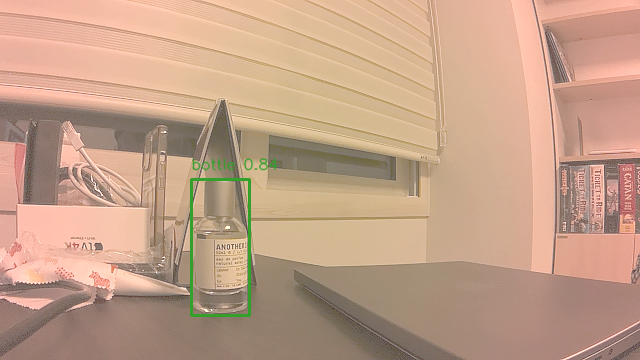

In [7]:
draw_boxes(image, pred, classes, colors)
Image.fromarray(image)

In [8]:
model.device

device(type='cuda', index=0)

In [9]:
pred

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [10]:
## Convert PyTorch model to TensorRT-fp16 model
# Takes about 10 mins
# ref: https://github.com/ultralytics/ultralytics/blob/main/ultralytics/engine/exporter.py
import os

if not os.path.exists('yolov8n.pytorch.engine'):
    YOLO("yolov8n.pytorch.pt").export(format='engine', device=0, half=True)

Loading yolov8n.pytorch.engine for TensorRT inference...


[04/18/2024-04:12:58] [TRT] [I] Loaded engine size: 8 MiB
[04/18/2024-04:12:58] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +22, now: CPU 1953, GPU 5605 (MiB)
[04/18/2024-04:12:58] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +6, now: CPU 0, GPU 6 (MiB)
[04/18/2024-04:12:58] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +27, now: CPU 1945, GPU 5632 (MiB)
[04/18/2024-04:12:58] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +9, now: CPU 0, GPU 15 (MiB)

0: 640x640 1 bottle, 10.4ms
Speed: 3.2ms preprocess, 10.4ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)


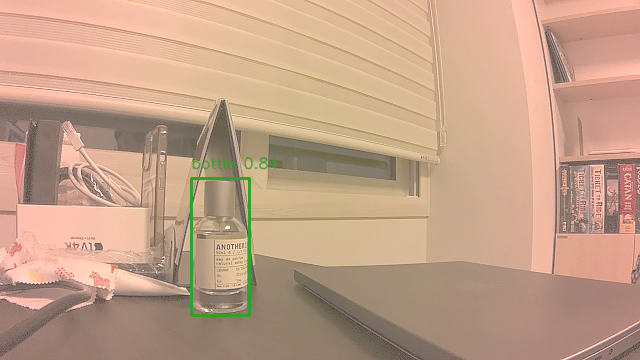

In [11]:
# Run inference
model = YOLO("yolov8n.pytorch.engine", task='detect')
image = copy.deepcopy(frame)
pred = model(image, stream=False)

draw_boxes(image, pred, classes, colors)
Image.fromarray(image)